# Compare Classified Images to Predict Poverty

In [5]:
import descarteslabs as dl
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
from descarteslabs.client.services import Catalog
from osgeo import gdal
%matplotlib inline

### Defined boundary of Burundi

In [4]:
matches = dl.places.find('burundi')
aoi = matches[0]
pprint(aoi)

shape = dl.places.shape(aoi['slug'], geom='low')

{
  u'bbox': [29.001302, -4.468538, 30.849959, -2.309987],
  u'id': 85632285,
  u'name': u'Burundi',
  u'path': u'continent:africa_country:burundi',
  u'placetype': u'country',
  u'slug': u'africa_burundi'
}


### Get classified urban and night lights results from the Descartes Labs client.

In [2]:
night_light = dl.metadata.search('7294028cc01114d89a473cf055d29dc5cd5ffe88:Burundi_Night_Lights')['features'][0]['id']

In [3]:
urban_areas = dl.metadata.search('7294028cc01114d89a473cf055d29dc5cd5ffe88:Burundi_Urban')['features'][0]['id']

In [6]:
print(night_light)
print(urban_areas)

7294028cc01114d89a473cf055d29dc5cd5ffe88:Burundi_Night_Lights:night_lights_classification
7294028cc01114d89a473cf055d29dc5cd5ffe88:Burundi_Urban:urban_classification


### Clip classified imagery to the boundary of Burundi

(681, 586)
(681, 586)


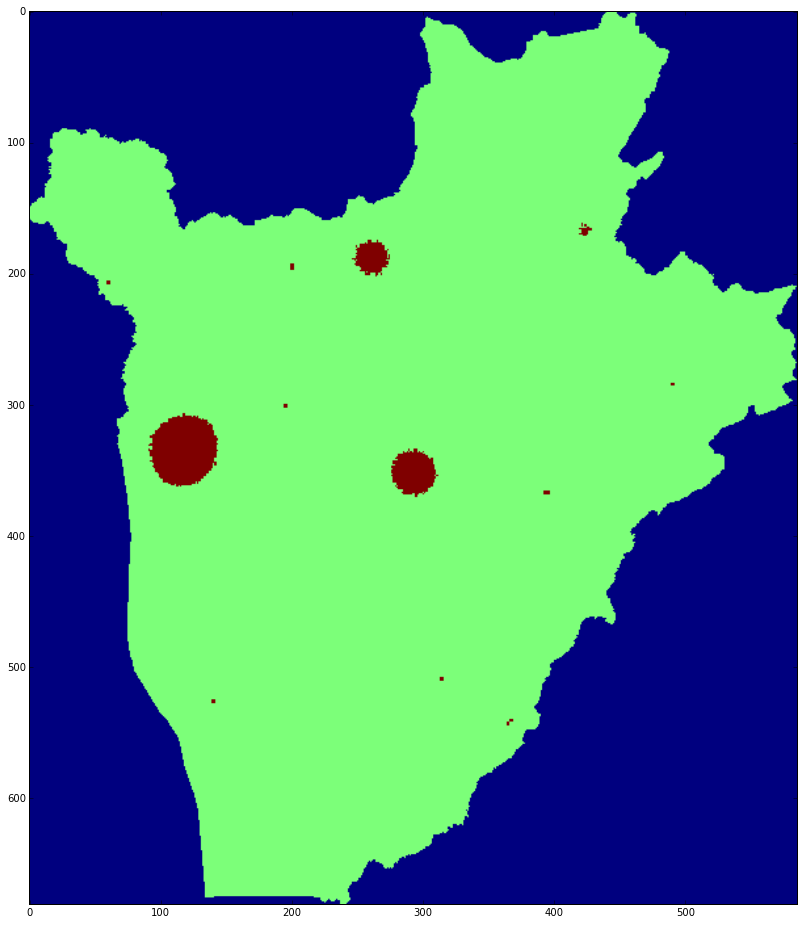

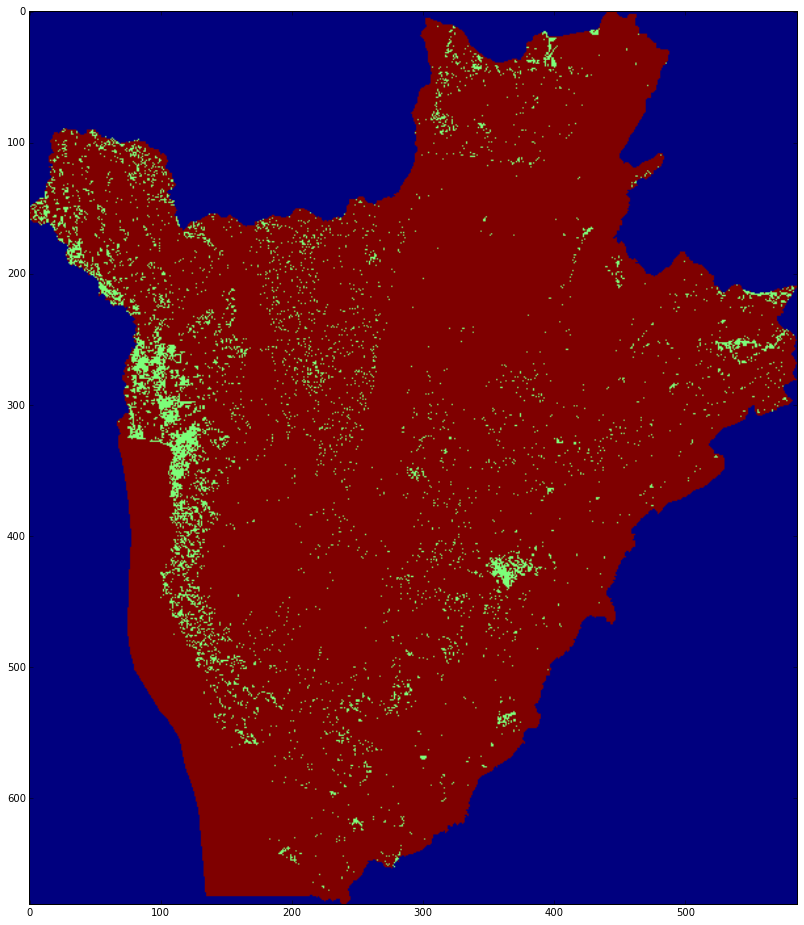

In [17]:
arr_night, meta_night = dl.raster.ndarray(night_light, cutline=shape['geometry']) 

arr_urban, meta_urban = dl.raster.ndarray(urban_areas, cutline=shape['geometry'])

print(arr_night.shape)
print(arr_urban.shape)

from matplotlib import pyplot as plt

plt.figure(figsize=[16,16])
plt.imshow(arr_night)


plt.figure(figsize=[16,16])
plt.imshow(arr_urban)

In [22]:
print(np.unique(arr_night, return_counts=True))
print(arr_night.shape)
print(np.unique(arr_urban, return_counts=True))
print(arr_urban.shape)

(array([ 0.,  1.,  2.]), array([180769, 214539,   3758]))
(681, 586)
(array([ 0.,  1.,  2.]), array([181120,   9867, 208079]))
(681, 586)


### Subtract the night lights image from the urban classification. The result are unique codes with specific meaning.

Manipulate the data values so we can create a key of interest indicating areas that are both classified as Urban and Dark.  
Night image classified:  
    0 = nodata  
    2 = dark  
    4 = light   
    
Urban classification:  
    0 = nodata  
    1 = urban   
    2 = other   

In [25]:
code_night = arr_night*2

Subtract the night lights image from the urban classification, yielding a coded image where:  

0, -1, -2, 2, 4 = no data    
**1 = poverty (dark and urban)**  
0 = dark and other   
2 = light and other   
3 = light and urban   

In [39]:
coded_image = code_night - arr_urban
other_codes = [-2, -1, 0, 2, 3]
print(np.unique(coded_image, return_counts= True))
for code in other_codes:
    coded_image[coded_image == code] = np.nan

(array([-2., -1.,  0.,  1.,  2.,  3.]), array([   253,     23, 385422,   8983,   3524,    861]))


(array([  1.,  nan,  nan, ...,  nan,  nan,  nan]), array([8983,    1,    1, ...,    1,    1,    1]))


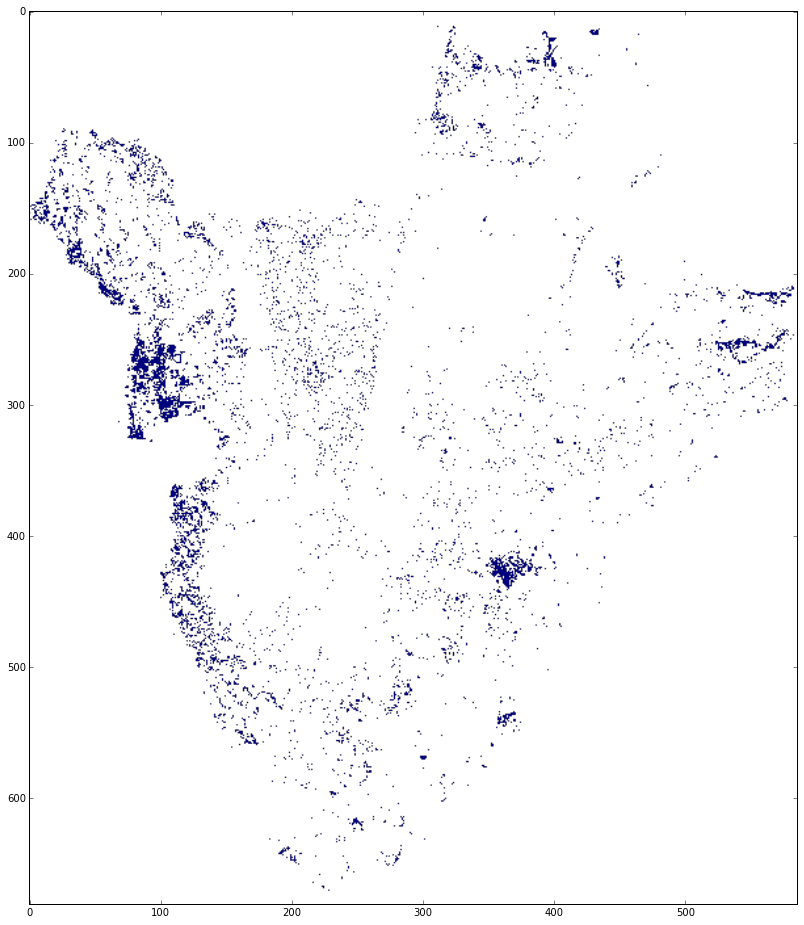

In [41]:
print(np.unique(coded_image, return_counts= True))
plt.figure(figsize=[16,16])
plt.imshow(coded_image)

## Smooth and Display Poverty Predictor

(array([ 0.,  1.]), array([390083,   8983]))


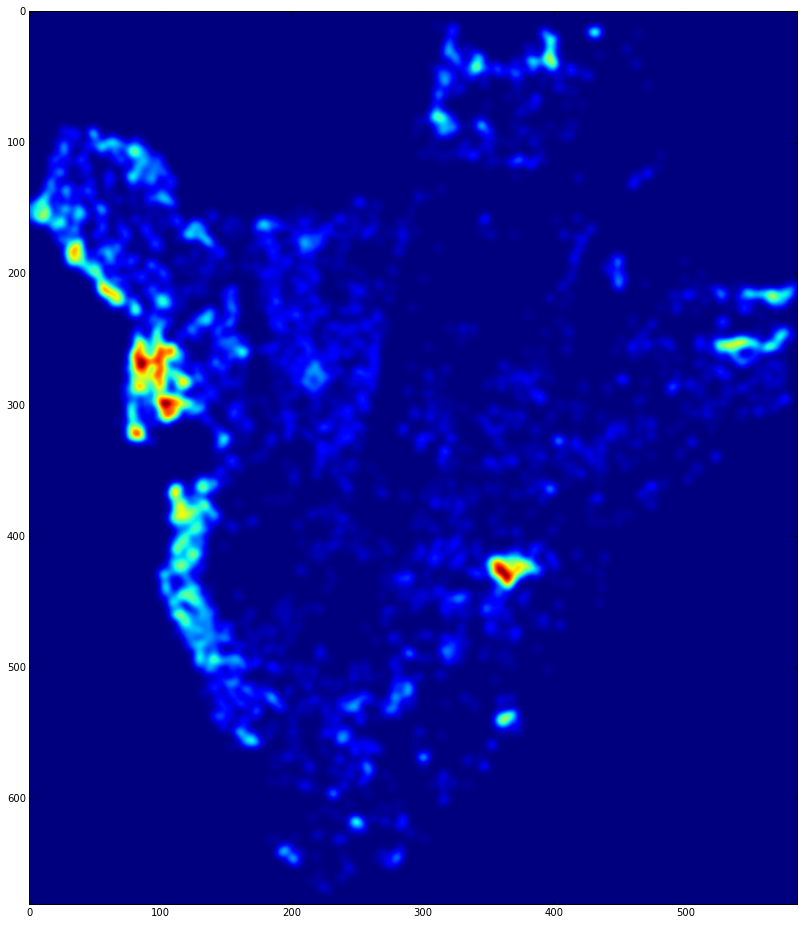

In [17]:
import scipy as sp
import numpy as np
from scipy import ndimage
poverty_predicted = dl.metadata.search('7294028cc01114d89a473cf055d29dc5cd5ffe88:Poverty_Predicted_Burundi')['features'][0]['id']
arr, meta = dl.raster.ndarray(poverty_predicted)
print(np.unique(arr, return_counts=True))
filtered= sp.ndimage.gaussian_filter(arr,sigma=3)
from matplotlib import pyplot as plt

plt.figure(figsize=[16,16])
plt.imshow(filtered)

### Prepare Final Product for Upload

In [18]:
def write_geotiff(fname, data, geo_transform, projection):
    """Create a GeoTIFF file with the given data."""
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = data.shape
    dataset = driver.Create(fname, cols, rows, 1, gdal.GDT_Byte)
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)
    band = dataset.GetRasterBand(1)
    band.WriteArray(data)
    dataset = None  # Close the file

In [19]:
geo_transform = [55210.738, 351.263936239, 0.0, -255587.129, 0.0, -351.263936239]

proj = 'PROJCS["WGS 84 / UTM zone 36N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",33],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32636"]]'


In [21]:
write_geotiff("data/derived/poverty_predicted_filtered.tiff", filtered, geo_transform, proj)

### Upload Final Product to Platform 

In [22]:
Catalog().add_product('Poverty_Heat_Map_Burundi', 
                      title='Poverty_Heat_Map_Burundi', 
                      description='Areas where poverty has been detected given the comparison of urban and night lights satellite information. The final product is a heat map with a Gau'
                     )

{u'data': {u'attributes': {u'description': u'Areas where poverty has been detected given the comparison of urban and night lights satellite information. The final product is a heat map with a Gau',
   u'read': [],
   u'title': u'Poverty_Heat_Map_Burundi'},
  u'id': u'7294028cc01114d89a473cf055d29dc5cd5ffe88:Poverty_Heat_Map_Burundi',
  u'meta': {u'owner': {u'email': None,
    u'name': u'Karla King',
    u'uuid': u'google-oauth2|101598335967461239621'},
   u'owner_type': u'user'},
  u'type': u'product'}}

In [23]:
Catalog().add_band(product_id='7294028cc01114d89a473cf055d29dc5cd5ffe88:Poverty_Heat_Map_Burundi', name='poverty', srcband=1, nbits=64,dtype='Float64',type='class',data_range=[0, 1.000],colormap_name='inferno')

{u'data': {u'attributes': {u'colormap_name': u'inferno',
   u'data_range': [0, 1.0],
   u'default_range': None,
   u'dtype': u'Float64',
   u'jpx_layer': 0,
   u'name': u'poverty',
   u'nbits': 64,
   u'nodata': None,
   u'read': [],
   u'res_factor': 1,
   u'srcband': 1,
   u'srcfile': 0,
   u'type': u'class'},
  u'id': u'7294028cc01114d89a473cf055d29dc5cd5ffe88:Poverty_Heat_Map_Burundi:poverty',
  u'meta': {u'owner': {u'email': None,
    u'name': u'Karla King',
    u'uuid': u'google-oauth2|101598335967461239621'},
   u'owner_type': u'user'},
  u'relationships': {u'product': {u'data': {u'id': u'7294028cc01114d89a473cf055d29dc5cd5ffe88:Poverty_Heat_Map_Burundi',
     u'type': u'product'}}},
  u'type': u'band'}}

In [24]:
image_on_disc = '/Users/karlaking/descarteslabs-code/poverty-predictor/data/derived/poverty_predicted_filtered.tiff'
acquired_date = '2018-04-08'

Catalog().upload_image(image_on_disc,
                       '7294028cc01114d89a473cf055d29dc5cd5ffe88:Poverty_Heat_Map_Burundi',  
                       acquired=acquired_date)